In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import datagen
from utils import datatreat
from utils import solve_ridge

In [2]:
np.random.seed(1)

In [3]:
A_,y_ = datagen()
n,p,n_train,n_test,A,y,A_test,y_test = datatreat(A_,y_,0.6)

Number of obs: 173
n train: 103
n test: 70
Number of explicative variables: 9


In [4]:
def mse_ridge(x,lbd): return 0.5*np.linalg.norm(A@x-y)**2/n_train+0.5*lbd*np.linalg.norm(x)**2

In [5]:
lbd1=0.1
lbd2=5

x0,trash=solve_ridge(A,y,0)
x1,trash=solve_ridge(A,y,lbd1)
x2,trash=solve_ridge(A,y,lbd2)

In [6]:
print("Norm of x with lambda=%.1f: "%0,np.round(np.linalg.norm(x0),3))
print(x0)

print("Norm of x with lambda=%.2f: "%lbd1,np.round(np.linalg.norm(x1),3))
print(x1)

print("Norm of x with lambda=%.1f: "%lbd2,np.round(np.linalg.norm(x2),3))
print(x2)

Norm of x with lambda=0.0:  5.295
[1.55005263 2.26343997 0.64557462 2.82098553 0.64259705 1.62561205
 1.11312589 1.2918067  2.48540551]
Norm of x with lambda=0.10:  4.937
[1.51234584 1.81786824 1.05966036 2.58615889 0.81948639 1.50306634
 1.17136137 1.33581472 2.21005061]
Norm of x with lambda=5.0:  2.26
[0.88544134 0.83496142 0.81579881 0.67714247 0.76494586 0.56591435
 0.6436692  0.74187305 0.79543403]


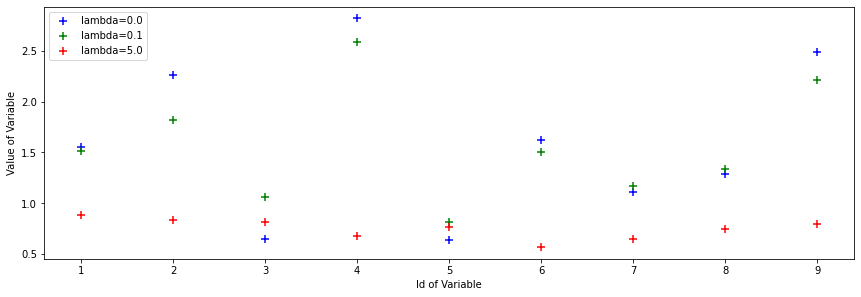

In [7]:
plt.scatter(np.arange(1,10),x0,color='blue',marker='+',label='lambda=%.1f'%0,s=50)
plt.scatter(np.arange(1,10),x1,color='green',marker='+',label='lambda=%.1f'%lbd1,s=50)
plt.scatter(np.arange(1,10),x2,color='red',marker='+',label='lambda=%.1f'%lbd2,s=50)
plt.xlabel("Id of Variable")
plt.ylabel("Value of Variable")
plt.legend(loc='upper left');
plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=None, hspace=None)

In [8]:
def mse_elastic_net(x,lbd,mu): return 0.5*np.linalg.norm(A@x-y)**2/n_train+0.5*lbd*np.linalg.norm(x)**2+mu*np.linalg.norm(x,1)

def dmse_ridge(x,lbd): return A.T@(A@x-y)/n_train+lbd*x

def ISTA(tau,lbd,mu,x_0,n_iter):
    x=np.zeros((n_iter,x_0.size))
    x[0]=x_0
    
    fx=np.full(n_iter,mse_elastic_net(x[0],lbd,mu))
    tau=tau*np.ones(n_iter)
    
    for i in range(1,n_iter):
        
        grad_ridge=dmse_ridge(x[i-1],lbd)
        iter_GD=x[i-1]-tau[i]*grad_ridge
        
        ind_left=np.argwhere(iter_GD<-tau[i]*mu)
        ind_right=np.argwhere(iter_GD> tau[i]*mu)

        x[i,ind_left]= iter_GD[ind_left]+tau[i]*mu
        x[i,ind_right]= iter_GD[ind_right]-tau[i]*mu

        fx[i]=mse_elastic_net(x[i],lbd,mu)
        
    return x,fx
    

In [9]:
lbd=0.022857142857142857
x_0=np.ones(A.shape[1])
tau=0.1
n_iter=100

mu=np.array([0.,1.,2.,3.,4.,5.,6.])
N_mu=mu.size

x=np.zeros((N_mu,n_iter,A.shape[1]))
Nb_of_zeros=np.ones(N_mu).astype(int)

for i in range(N_mu):

    x[i],trash=ISTA(tau,lbd,mu[i],x_0,n_iter)
    Nb_of_zeros[i]=np.count_nonzero(x[i,-1]==0)
    print("mu=%.0f: Number of zeros="%mu[i],Nb_of_zeros[i])

mu=0: Number of zeros= 0
mu=1: Number of zeros= 0
mu=2: Number of zeros= 0
mu=3: Number of zeros= 1
mu=4: Number of zeros= 3
mu=5: Number of zeros= 5
mu=6: Number of zeros= 7


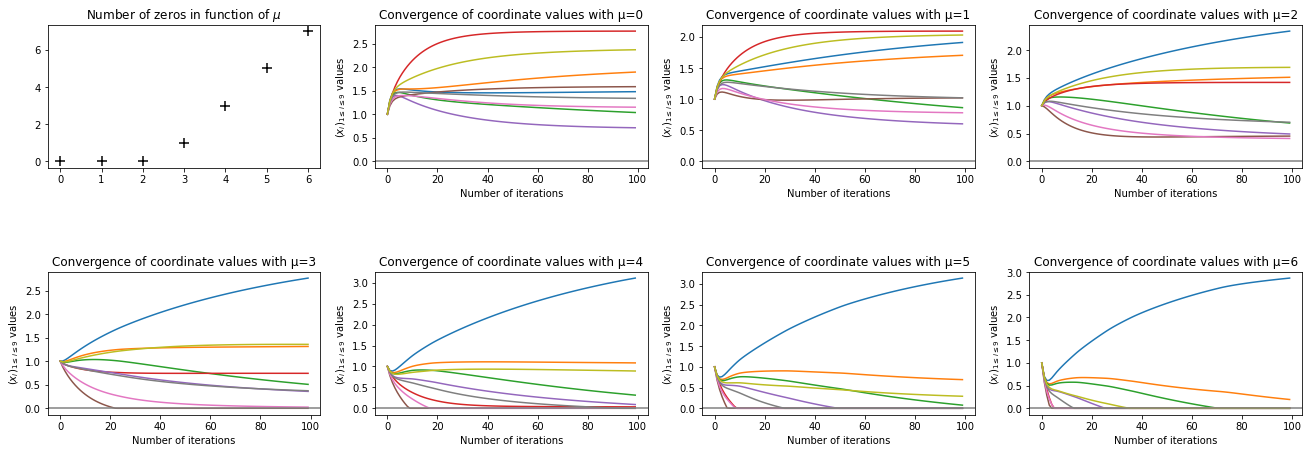

In [10]:
fig, ((ax0,ax1,ax2,ax3),(ax4,ax5,ax6,ax7)) = plt.subplots(nrows=2,ncols=4)

ax0.scatter(mu,Nb_of_zeros,color='black',marker='+',s=100)
ax0.set_title("Number of zeros in function of $\mu$")

ax=[ax1,ax2,ax3,ax4,ax5,ax6,ax7]

for i in range(0,N_mu):
    ax[i].plot(x[i])
    ax[i].axhline(0,color="grey")
    ax[i].set_title("Convergence of coordinate values with µ=%.0f"%mu[i])
    ax[i].set_xlabel("Number of iterations")
    ax[i].set_ylabel("$(x_i)_{1\leq i \leq 9}$ values")



fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(left=None, bottom=None, right=3, top=1.5, wspace=0.2, hspace=None)

In [11]:
def mse_test(x): return np.linalg.norm(A_test@x-y_test)**2/n_test
x0,trash0=solve_ridge(A,y,0)
f_test0=mse_test(x0)

f_test=np.zeros(N_mu)

for i in range(N_mu):
    f_test[i]=mse_test(x[i,-1])
    
print("Solution by minimizing mse vanilla: ",f_test0)
print("Solution by minimizing elastic net: ",f_test) 

Solution by minimizing mse vanilla:  5.543818661163919
Solution by minimizing elastic net:  [ 5.56298257  7.42404873 13.45203449 23.43782296 36.57344807 46.95951165
 57.96436243]


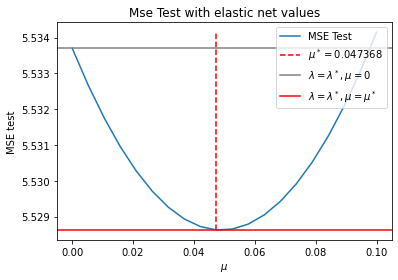

In [12]:
n_iter=1000

mu=np.linspace(0,.1,20)
N_mu=mu.size
f_search=np.zeros(N_mu)

x_ridge_lambda,trash = solve_ridge(A,y,lbd)
f_lambda = mse_test(x_ridge_lambda)

for i in range (N_mu):
    x,trash=ISTA(tau,lbd,mu[i],x_0,n_iter)
    f_search[i]=mse_test(x[-1])

i_opti = f_search.argmin()
mu_opti = mu[i_opti]

plt.title("Mse Test with elastic net values")
plt.plot(mu,f_search,label='MSE Test')
plt.plot( [mu_opti,mu_opti], [f_search.min(), f_search.max()], 'r--',label="$\mu^*=$%f"%mu_opti)
plt.xlabel('$\mu$');
plt.ylabel('MSE test');
plt.axhline(f_lambda,label='$\lambda=\lambda^*, \mu=0$',color='grey')
plt.axhline(f_search[i_opti],label='$\lambda=\lambda^*, \mu=\mu^*$',color='red')

plt.legend(loc="upper right");